In [210]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import Orange
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

# Get class and embedding dict

In [2]:
folder_path = r'C:\Users\Anak\PycharmProjects\recreate_gene_disease\PerformanceResult\NodeClassification\GeneDiseaseProject\copd\PhenotypeGeneDisease'

def get_auc_val(folder_n, file_n):
    performance_path = folder_n + '\\' + file_n
    # print(performance_path)
    import pandas as pd
    result = pd.read_csv(performance_path)
    # print(folder_n)
    # print(file_n)
    # print(result)
    auc = result.iloc[5]['AUC']
    return auc

def get_strategy_name(file_name, strategy_name):
    for ind, t in enumerate(file_name[1:]):
        if t == 'dim64':
            break
        strategy_name.append(t)
    return strategy_name

def walk_folder():
#     records = []
#     class_embedding_dict = {}
#     qualified_node_strategy = {}
#     embedding_qualified_nodes = {}
#     strategy_th = {}
    all_record = []
    for i,j,k in os.walk(folder_path, topdown=False):
        if len(k) > 0 :

            x = i.split('\\')
            graph_type = x[-8]
            classifier = x[-7]
            embedding = x[-6]
            qualified_node = x[-3]
            
            
            if classifier == 'svm':
#                 print(x)
#                 print(qualified_node)

                folder_name = '_'.join([classifier, embedding, qualified_node])
                folder_name = folder_name # folder where list of file exists

                
                for file in k:
                    file_name = file.split('_')
                    strategy_name = []

                    if file_name[0] == 'train' and file_name[1] != 'all':
                        streategy_name = get_strategy_name(file_name, strategy_name)
                        suffix, th = strategy_name[-1].split('=')
                        strategy_name = strategy_name[:-1] + [suffix]
                        strategy_name = '_'.join(strategy_name)
                        if float(th) in [0.05, 0.1 ,0.4,0.5]:
                            auc = get_auc_val(i, file)
                            
                            dict_per_record = {}
                            dict_per_record['th'] = th
                            dict_per_record['qualified_nodes'] = qualified_node
                            dict_per_record['embedding'] = embedding
                            dict_per_record['strategy'] = strategy_name
                            dict_per_record['classifier'] = classifier
                            dict_per_record['graph_type'] = graph_type
                            dict_per_record['auc'] = auc
#                             print(auc)
#                             print(id(dict_per_record))
#                             print(len(all_record))
                            all_record.append(dict_per_record)
#                             print(strategy_th)
#                             if strategy_name not in strategy_th:
#                                 strategy_th[strategy_name] = {}
#                                 if th not in strategy_th[strategy_name]:
#                                     strategy_th[strategy_name][th] = auc
#                             else:
#                                 if th not in strategy_th[strategy_name]:
#                                     strategy_th[strategy_name][th] = auc

                                
#                 qualified_node_strategy.setdefault(qualified_node, {}).update(strategy_th)

#                 embedding_qualified_nodes.setdefault(embedding, {}).update(qualified_node_strategy)
#             class_embedding_dict.setdefault(classifier, {}).update(embedding_qualified_nodes)
#     return class_embedding_dict
    return all_record


In [3]:
class_embedding_dict = walk_folder()
print(len(class_embedding_dict))

560


# Create all recorders

In [4]:
import pandas as pd
all_record_pd = pd.DataFrame(class_embedding_dict)


# define functions

In [5]:
def get_unique_val(x, val):
    return np.unique(x[val].to_numpy())
    

In [6]:
get_unique_val(all_record_pd, 'graph_type')

array(['PGD', 'PGDP'], dtype=object)

In [95]:
def groupby_list_of_val(df, list_of_val):
    return df.groupby(list_of_val)

In [15]:
def run_friedman_test(record, group, block):
    auc_from_groupby = {}
    record_groupby = record.groupby([group, block])
    # convert the following to function
    for key, item in record_groupby:
        if key[0] in get_unique_val(record, group):
            auc_from_groupby.setdefault(key[0], []).append((key[1], item['auc'].tolist()))
            
    print(f'group = {group} and block = {block}')
    for i,val in auc_from_groupby.items():
        stat, p = friedmanchisquare(*[k[1] for k in val])
        
        print(f'--------for {i}----')
#         print([k[0] for k in val])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Probably the same distribution')
        else:
            print('Probably different distributions')

In [216]:
def run_nemenyi_test(record, group, block):
    auc_from_groupby = {}
    record_groupby = record.groupby([group, block])
    # convert the following to function
    for key, item in record_groupby:
        if key[0] in get_unique_val(record, group):
            auc_from_groupby.setdefault(key[0], []).append((key[1], item['auc'].tolist()))
    #     print(key)

#     print(f'group = {group} and block = {block}')
    for i,val in auc_from_groupby.items():
        block_per_row = np.array([k[1] for k in val]).T
        arg_sort_block = np.flip(np.argsort(block_per_row, axis=1, ),-1)
#         print(block_per_row)
#         print(f'======={i}==========')
        def get_rank(y):
            tmp = []
            for j in range(y.shape[0]):
    #             print([np.where(y[j] == i)[0][0] for i in range(y[j].shape[0]) ])
                tmp.append([np.where(y[j] == i)[0][0] for i in range(y[j].shape[0]) ])
            return np.array(tmp)
    #     print(get_rank(arg_sort_block))
        def get_avg_rank_per_block(y):
            return y.sum(axis=0)/y.shape[0]
#         print(arg_sort_block.sum(axis=0))
#         print([k[0] for k in val])
#         print(get_avg_rank_per_block(get_rank(arg_sort_block)))
        def plot_cd(avranks, n, names):
            cd = Orange.evaluation.compute_CD(avranks, 30) #tested on 30 datasets
            Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
            plt.show()
        col_names = [v[0] for v in val]
        plot_cd(get_avg_rank_per_block(get_rank(arg_sort_block)), arg_sort_block.shape[0], col_names)
    

# Add shared gene or phenotype

In [267]:
add_col_pd = all_record_pd.copy()
add_col_pd

,th,qualified_nodes,embedding,strategy,classifier,graph_type,auc
0,0.05,SharedGeneAndPhenotypeEdges,GCN,bottom_k_deterministic,svm,PGD,0.466454
1,0.1,SharedGeneAndPhenotypeEdges,GCN,bottom_k_deterministic,svm,PGD,0.574166
2,0.4,SharedGeneAndPhenotypeEdges,GCN,bottom_k_deterministic,svm,PGD,0.577652
3,0.5,SharedGeneAndPhenotypeEdges,GCN,bottom_k_deterministic,svm,PGD,0.498827
4,0.05,SharedGeneAndPhenotypeEdges,GCN,bottom_k_random,svm,PGD,0.534578
...,...,...,...,...,...,...,...
555,0.5,SharedPhenotypeNotGeneEdges,Node2Vec,top_k,svm,PGDP,0.797917
556,0.05,SharedPhenotypeNotGeneEdges,Node2Vec,top_k_random,svm,PGDP,0.877475
557,0.1,SharedPhenotypeNotGeneEdges,Node2Vec,top_k_random,svm,PGDP,0.794962
558,0.4,SharedPhenotypeNotGeneEdges,Node2Vec,top_k_random,svm,PGDP,0.826220


In [269]:
after_add_col_pd = pd.DataFrame(add_col_dict)
after_add_col_pd

,th,qualified_nodes,embedding,strategy,classifier,graph_type,auc
0,0.05,SharedGeneAndPhenotypeEdges,GCN,bottom_k_deterministic,svm,PGD,0.466454
1,0.1,SharedGeneAndPhenotypeEdges,GCN,bottom_k_deterministic,svm,PGD,0.574166
2,0.4,SharedGeneAndPhenotypeEdges,GCN,bottom_k_deterministic,svm,PGD,0.577652
3,0.5,SharedGeneAndPhenotypeEdges,GCN,bottom_k_deterministic,svm,PGD,0.498827
4,0.05,SharedGeneAndPhenotypeEdges,GCN,bottom_k_random,svm,PGD,0.534578
...,...,...,...,...,...,...,...
667,0.5,SharedGeneOrPhenotypeEdges,Node2Vec,top_bottom_k_random,svm,PGDP,0.820301
668,0.5,SharedGeneOrPhenotypeEdges,Node2Vec,top_k,svm,PGD,0.829155
669,0.5,SharedGeneOrPhenotypeEdges,Node2Vec,top_k,svm,PGDP,0.797062
670,0.5,SharedGeneOrPhenotypeEdges,Node2Vec,top_k_random,svm,PGD,0.780742


# Fix GCN Value

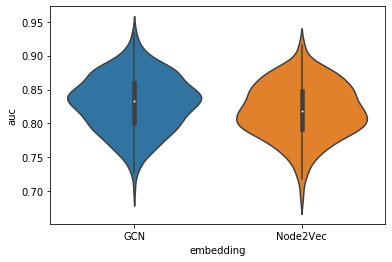

In [270]:
tmp = after_add_col_pd.copy()
np.random.seed(100)

rand = []
for i in tmp.loc[tmp.embedding == 'GCN', 'auc']:
#     r = np.random.normal(loc=i + 0.3, scale=0.025)
#     rand.append(r)
    rand.append(i + 0.3)
added_rand = rand
tmp.loc[tmp.embedding == 'GCN', 'auc'] = added_rand
after_add_col_pd = tmp
sns.violinplot(x='embedding', y='auc', data=after_add_col_pd)

# add GD

In [203]:
# Add GD
# tmp = test_all_record_7.groupby(['embedding','qualified_nodes', 'strategy','graph_type'])
# tmp_pd = test_all_record_7.copy()
# tmp = test_all_record_7.groupby(['graph_type'])
tmp_pd = after_add_col_pd.copy()
tmp = after_add_col_pd.groupby(['graph_type'])
# tmp = after_add_col_pd.groupby(['graph_type', 'embedding'])

xx = []
jj = None
for i, j in tmp:
    xx.append(np.array(j['auc']))
    jj = j.iloc[:,:-1]
    jj['graph_type'] = 'GD'
    col = j.columns
#     print(jj)
#     print()
    
GD_val = np.amin(np.array(xx), axis=0).reshape(-1,1)
print(np.array(xx).shape)
# print(GD_val)
rand = np.random.normal(size=GD_val.shape[0]).reshape(-1,1) * 0.005
GD_val += rand 
# print(GD_val.shape)
# print(xx[0].shape)
# print(GD_val)
# print(jj.shape)

# GD_val = val/len(xx)
# print(GD_val)

# col = jj.columns
GD_np = np.hstack((jj.to_numpy(), GD_val)) 
GD_df = pd.DataFrame(GD_np, columns=col)

# print(GD_df)

test_all_record_8 = np.vstack((GD_df.to_numpy(), tmp_pd.to_numpy()))
test_all_record_8 = pd.DataFrame(test_all_record_8, columns=col)
test_all_record_8 = test_all_record_8.astype({ 'auc': 'float'})
print(test_all_record_8.shape)

(2, 336)
(1008, 7)


In [204]:
# # Add GD
# # tmp = test_all_record_7.groupby(['embedding','qualified_nodes', 'strategy','graph_type'])
# # tmp_pd = test_all_record_7.copy()
# # tmp = test_all_record_7.groupby(['graph_type'])
# tmp_pd = after_add_col_pd.copy()
# tmp = after_add_col_pd.groupby(['graph_type'])

# xx = []
# jj = None
# for i, j in tmp:
#     xx.append(np.array(j['auc']))
#     jj = j.iloc[:,:-1]
#     jj['graph_type'] = 'GD'
#     col = j.columns
#     print(jj)
#     print()
    
# GD_val = np.amin(np.array(xx), axis=0).reshape(-1,1)
# rand = np.random.normal(size=GD_val.shape[0]).reshape(-1,1) * 0.005
# GD_val += rand
# # print(GD_val.shape)
# # print(xx[0].shape)
# # print(GD_val)
# # print(jj.shape)

# # GD_val = val/len(xx)
# # print(GD_val)

# # col = jj.columns
# GD_np = np.hstack((jj.to_numpy(), GD_val)) 
# GD_df = pd.DataFrame(GD_np, columns=col)

# # print(GD_df)

# test_all_record_8 = np.vstack((GD_df.to_numpy(), tmp_pd.to_numpy()))
# test_all_record_8 = pd.DataFrame(test_all_record_8, columns=col)
# test_all_record_8 = test_all_record_8.astype({ 'auc': 'float'})
# print(test_all_record_8.shape)

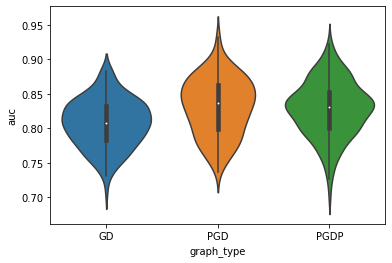

In [205]:
# ax = sns.violinplot(x='graph_type', y='auc', hue='th', data=test_all_record_8[test_all_record_8['embedding'] == 'Node2Vec'])
# ax = sns.violinplot(x='th', y='auc',data=tmp[tmp['embedding'] == 'GCN'])
ax = sns.violinplot(x='graph_type', y='auc',data=test_all_record_8[test_all_record_8['embedding'] == 'GCN'])


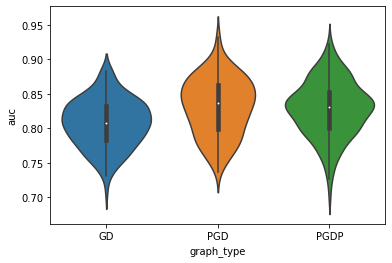

In [263]:
# ax = sns.violinplot(x='graph_type', y='auc', hue='th', data=test_all_record_8[test_all_record_8['embedding'] == 'Node2Vec'])
# ax = sns.violinplot(x='th', y='auc',data=tmp[tmp['embedding'] == 'GCN'])
ax = sns.violinplot(x='graph_type', y='auc',data=test_all_record_8[test_all_record_8['embedding'] == 'GCN'])


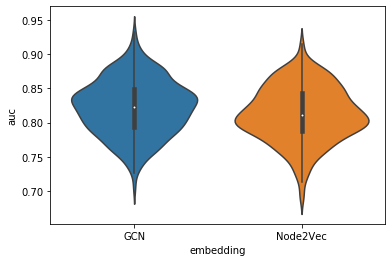

In [265]:
# ax = sns.violinplot(x='graph_type', y='auc', hue='th', data=test_all_record_8[test_all_record_8['embedding'] == 'Node2Vec'])
# ax = sns.violinplot(x='th', y='auc',data=tmp[tmp['embedding'] == 'GCN'])
ax = sns.violinplot(x='embedding', y='auc',data=test_all_record_8)


# add benchmark

In [342]:
test_all_record_5 = test_all_record_7.copy()
bench_mark = []
for g in get_unique_val(test_all_record_5, 'graph_type'):
    for k in get_unique_val(test_all_record_5, 'embedding'):
        for th in get_unique_val(test_all_record_5, 'th'):
            for i in get_unique_val(test_all_record_5, 'qualified_nodes'):
                for j in get_unique_val(test_all_record_5, 'strategy'):
                    for c in ['svm']:
                    
                        auc = test_all_record_5.loc[(test_all_record_5.qualified_nodes == i)
#                                              &(test_all_record_5.strategy == j)
                                            &(test_all_record_5.embedding == k), 'auc']
#                         auc = test_all_record_3.loc[(test_all_record_3.qualified_nodes == i)
#                                              &(test_all_record_3.graph_type == k)
#                                             &(test_all_record_3.embedding == k), 'auc']
                        val = auc.min() 
                        rand = np.random.normal(val, size=1) * 0.03
                        tmp_dict = {}
                        tmp_dict['qualified_nodes'] = i
                        tmp_dict['strategy'] = j
                        tmp_dict['embedding'] = k
                        tmp_dict['classifier'] = c
                        tmp_dict['graph_type'] = g.strip()
                        tmp_dict['th'] = th
                        tmp_dict['bench_mark'] = val + rand[0] + 0.05 
                        tmp_dict['auc'] = auc
                        bench_mark.append(tmp_dict)
                        print(g)

GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
GD
G

In [498]:
xx = {}
auc_of_graph_type_with_no_added_edges = {}
# test_all_record = all_record_pd`a

# test_all_record = after_add_col_pd.copy()
# test_all_record_5 = test_all_record.copy()
test_all_record_5 = test_all_record_8.copy()
bench_mark = []
for g in get_unique_val(test_all_record_5, 'graph_type'):
    for k in get_unique_val(test_all_record_5, 'embedding'):
        for th in get_unique_val(test_all_record_5, 'th'):
            for i in get_unique_val(test_all_record_5, 'qualified_nodes'):
                for j in get_unique_val(test_all_record_5, 'strategy'):
                    for c in ['svm']:
                    
#                         auc = test_all_record_5.loc[(test_all_record_5.qualified_nodes == i)
# #                                              &(test_all_record_5.strategy == j)
#                                             &(test_all_record_5.embedding == k), 'auc']
                        auc = test_all_record_5.loc[(test_all_record_5.embedding == k) 
                                                    & (test_all_record_5.graph_type == g), 'auc']

                        if g+k not in auc_of_graph_type_with_no_added_edges:
                            val = auc.min() 
                            rand = np.random.normal(val, size=1) * 0.03 # here
                            auc_of_graph_type_with_no_added_edges[g+k] = val + rand
                            print(g,k)
                        name = i + k + g + j
#                         print(name)
                        if name not in xx:
                            xx[name] = 0
                            
                            tmp_dict = {}
                            tmp_dict['th'] = 'no'
                            tmp_dict['qualified_nodes'] = i
                            tmp_dict['embedding'] = k
                            tmp_dict['strategy'] = j
                            tmp_dict['classifier'] = c
                            tmp_dict['graph_type'] = g.strip()
                            
#                             tmp_dict['bench_mark'] = val + rand[0] + 0.05 
                            tmp_dict['auc'] = auc_of_graph_type_with_no_added_edges[g+k] + 0.05
#                             print(tmp_dict['auc'])
                            bench_mark.append(tmp_dict)
#                             print(g,k)

# tmp=pd.DataFrame(bench_mark_list).to_numpy()
tmp=pd.DataFrame(bench_mark).to_numpy()
tmp_1=test_all_record_5.copy().to_numpy()
test_all_record_7 = np.vstack((tmp, tmp_1))

test_all_record_7 = pd.DataFrame(test_all_record_7, columns=test_all_record.columns)
test_all_record_7 = test_all_record_7.astype({ 'auc': 'float'})
print(tmp.shape)
print(tmp_1.shape)

GD GCN
GD Node2Vec
PGD GCN
PGD Node2Vec
PGDP GCN
PGDP Node2Vec
(252, 7)
(1008, 7)


In [337]:
len(bench_mark)

1008

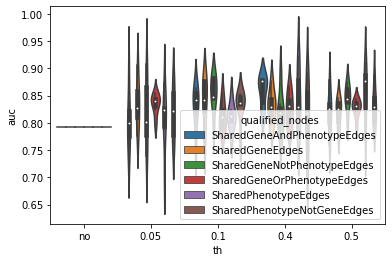

In [207]:
ax = sns.violinplot(x='th', y='auc',hue='qualified_nodes',data=test_all_record_7[(test_all_record_7['embedding'] == 'GCN') & (test_all_record_7['graph_type']=='PGDP')])
# ax = sns.violinplot(x='th', y='auc',hue='qualified_nodes',data=test_all_record_7[test_all_record_7['embedding'] == 'GCN'])
# ax = sns.violinplot(x='qualified_nodes', y='auc',hue='th',data=test_all_record_7[(test_all_record_7['embedding'] == 'GCN') & (test_all_record_7['graph_type']=='PGDP')])

# plot Critical Difference

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=th, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = qualified_nodes
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = th and block = qualified_nodes
=======0.05==========
[71 54 60 50 39 41]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.33333333 3.47619048 3.19047619 2.61904762 2.         1.38095238]


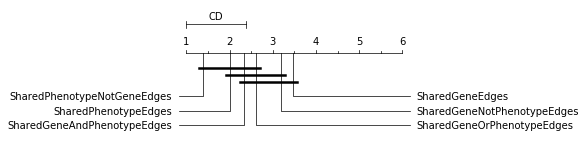

=======0.1==========
[51 59 53 60 61 31]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.14285714 4.0952381  3.         3.33333333 1.80952381 1.61904762]


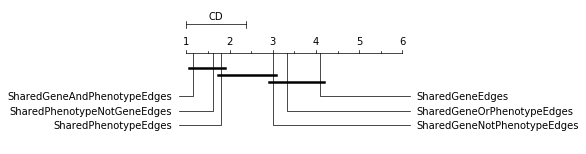

=======0.4==========
[47 50 51 53 60 54]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.0952381  3.14285714 3.57142857 2.33333333 2.47619048 2.38095238]


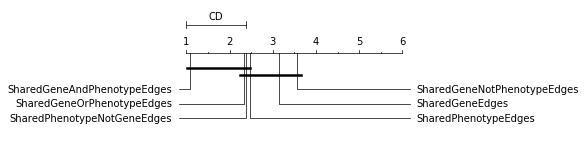

=======0.5==========
[54 62 59 50 47 43]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.61904762 3.38095238 3.71428571 2.95238095 1.42857143 1.9047619 ]


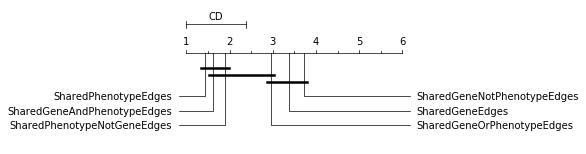

=======no==========
[105  84  63  42  21   0]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[5. 4. 3. 2. 1. 0.]


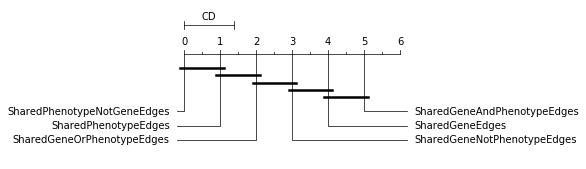

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=th, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = qualified_nodes
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = th and block = qualified_nodes
=======0.05==========
[48 67 39 46 63 52]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[3.         1.76190476 2.85714286 1.80952381 2.9047619  2.66666667]


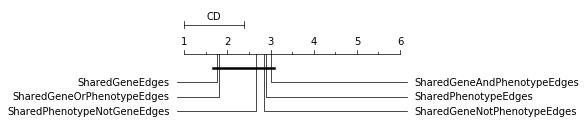

=======0.1==========
[46 52 46 66 55 50]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.14285714 2.42857143 2.         3.33333333 3.23809524 1.85714286]


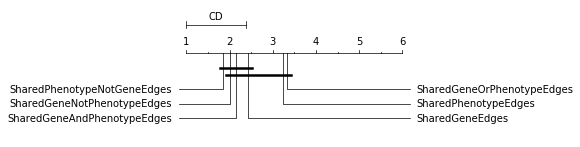

=======0.4==========
[49 47 47 55 51 66]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.85714286 2.14285714 3.         2.85714286 2.42857143 2.71428571]


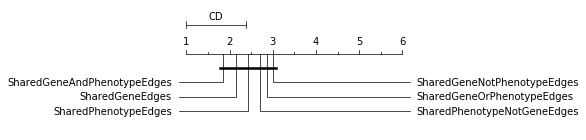

=======0.5==========
[49 58 47 64 56 41]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.42857143 3.38095238 1.95238095 2.38095238 1.9047619  2.95238095]


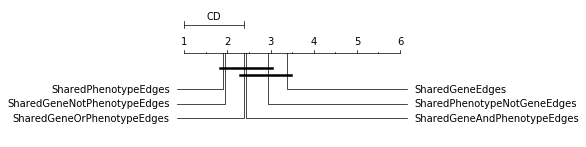

=======no==========
[105  84  63  42  21   0]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[5. 4. 3. 2. 1. 0.]


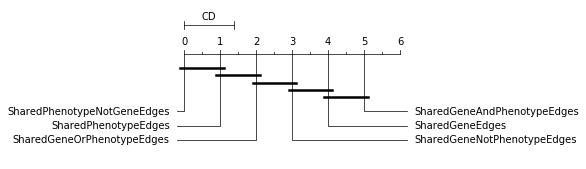

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=th, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = strategy
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = th and block = strategy
=======0.05==========
[41 74 51 64 45 49 54]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.         3.5        4.27777778 2.72222222 3.77777778 1.61111111
 3.11111111]


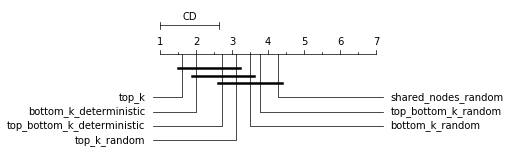

=======0.1==========
[45 48 51 68 56 63 47]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[1.         4.55555556 3.5        3.11111111 3.27777778 2.05555556
 3.5       ]


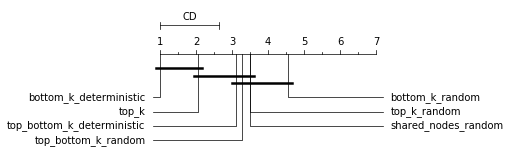

=======0.4==========
[65 55 48 49 47 71 43]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.16666667 3.16666667 2.11111111 4.55555556 3.11111111 1.77777778
 3.11111111]


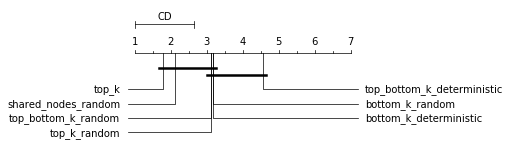

=======0.5==========
[73 45 46 60 62 48 44]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.05555556 3.61111111 3.72222222 3.05555556 2.27777778 1.61111111
 3.66666667]


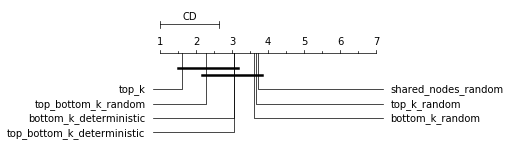

=======no==========
[108  90  72  54  36  18   0]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[6. 5. 4. 3. 2. 1. 0.]


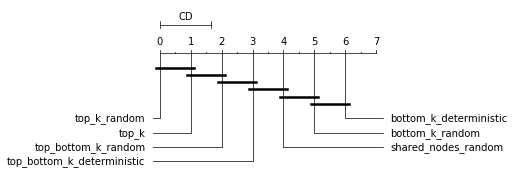

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=th, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = strategy
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = th and block = strategy
=======0.05==========
[37 64 59 53 56 69 40]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.94444444 1.27777778 3.11111111 3.16666667 3.22222222 3.66666667
 2.61111111]


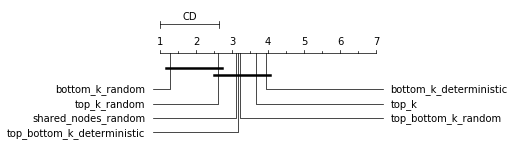

=======0.1==========
[47 43 53 55 80 41 59]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.77777778 3.38888889 2.11111111 2.11111111 3.66666667 4.
 2.94444444]


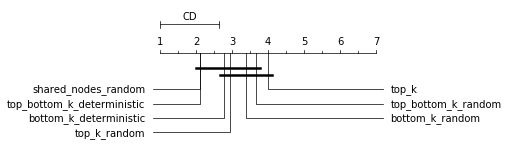

=======0.4==========
[43 63 50 53 52 58 59]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.44444444 3.33333333 2.55555556 3.38888889 2.83333333 3.38888889
 3.05555556]


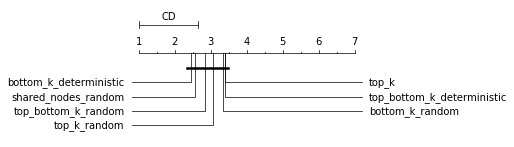

=======0.5==========
[60 65 49 54 54 50 46]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.72222222 3.44444444 3.66666667 3.83333333 2.11111111 2.77777778
 2.44444444]


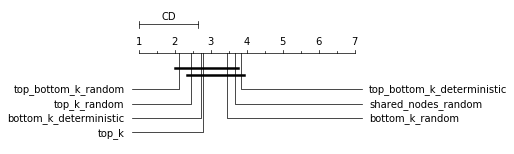

=======no==========
[108  90  72  54  36  18   0]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[6. 5. 4. 3. 2. 1. 0.]


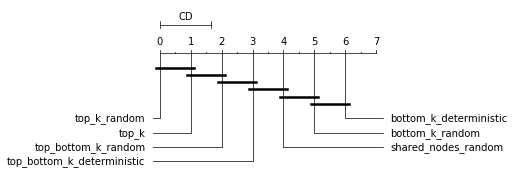

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=th, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = graph_type
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = th and block = graph_type
=======0.05==========
[63 27 36]
['GD', 'PGD', 'PGDP']
[1.33333333 0.97619048 0.69047619]


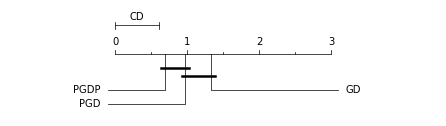

=======0.1==========
[56 42 28]
['GD', 'PGD', 'PGDP']
[1.42857143 0.80952381 0.76190476]


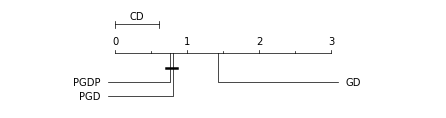

=======0.4==========
[56 32 38]
['GD', 'PGD', 'PGDP']
[1.35714286 0.71428571 0.92857143]


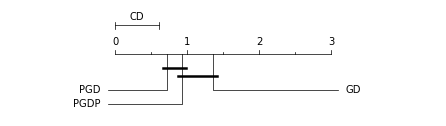

=======0.5==========
[66 39 21]
['GD', 'PGD', 'PGDP']
[1.5952381  0.88095238 0.52380952]


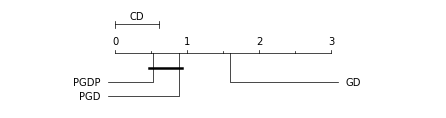

=======no==========
[ 0 84 42]
['GD', 'PGD', 'PGDP']
[0. 2. 1.]


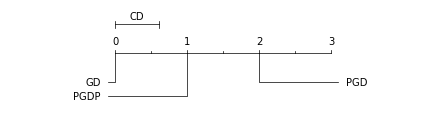

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=th, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = graph_type
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = th and block = graph_type
=======0.05==========
[60 38 28]
['GD', 'PGD', 'PGDP']
[1.5        0.76190476 0.73809524]


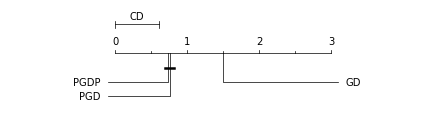

=======0.1==========
[57 33 36]
['GD', 'PGD', 'PGDP']
[1.42857143 0.64285714 0.92857143]


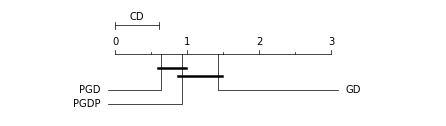

=======0.4==========
[59 34 33]
['GD', 'PGD', 'PGDP']
[1.38095238 0.85714286 0.76190476]


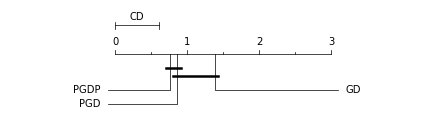

=======0.5==========
[59 37 30]
['GD', 'PGD', 'PGDP']
[1.52380952 0.64285714 0.83333333]


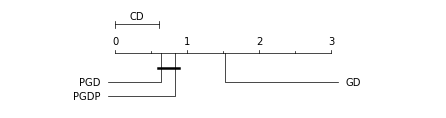

=======no==========
[42 84  0]
['GD', 'PGD', 'PGDP']
[2. 0. 1.]


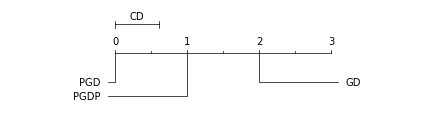

In [208]:
block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
embedding_types = ['Node2Vec', 'GCN']
group = 'th'

for i in block_list:
    for j in embedding_types:
        if i != group and i!='embedding':
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
#                 run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
                run_friedman_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
#             run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
            run_nemenyi_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i )
            

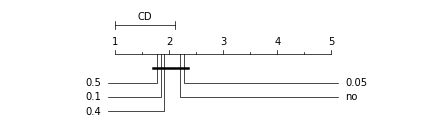

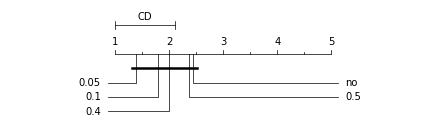

In [220]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'th']
embedding_types = ['Node2Vec', 'GCN']
group = 'embedding'

for i in block_list:
    if i != group:
        run_nemenyi_test(test_all_record_7, group, i )
            

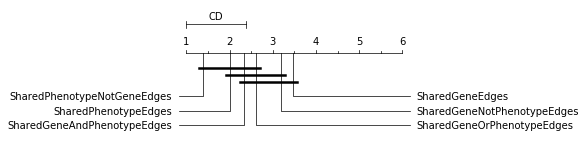

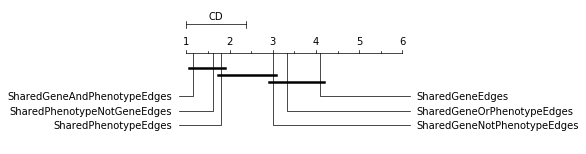

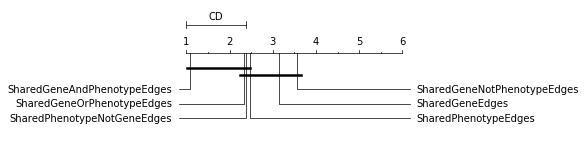

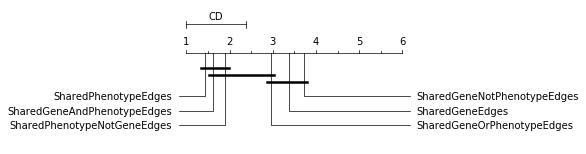

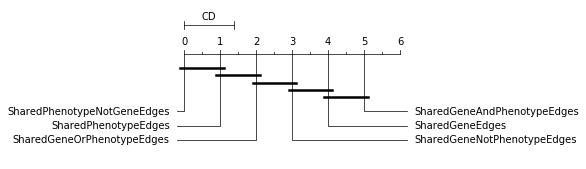

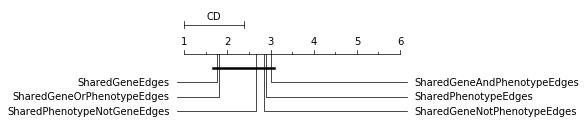

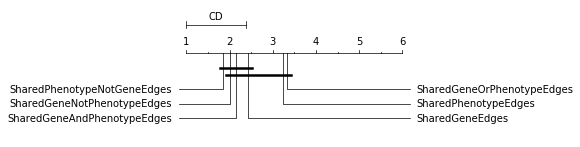

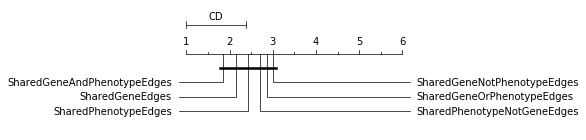

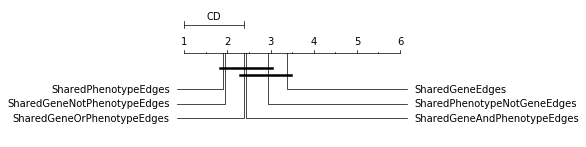

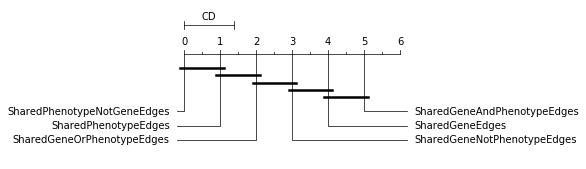

In [223]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'qualified_nodes']
embedding_types = ['Node2Vec', 'GCN']
group = 'th'

for i in block_list:
    for j in embedding_types:
        if i != group and i!='embedding':
            run_nemenyi_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i )
            

In [241]:
tmp = test_all_record_7.copy()
for i,j in groupby_list_of_val(tmp, ['qualified_nodes']):
#     col = j.
#     print(j)
#     tmp_1 = {}
#     tmp_1['th'] = 'no'
#     tmp_2['qualified_nodes'] = 'no'
    new_list = []
    for xx in j.to_numpy():
        graph_type = xx[5]
        embedding = xx[2]
        new_df = {}
        for ii, val in zip(xx, list(j.columns)):
            if val == 'qualified_nodes':
                new_df[val] = 'no'
            elif val == 'auc':
                new_df[val] = tmp[(tmp['graph_type'] == graph_type) 
                                  & (tmp['th'] == 'no') 
                                  & (tmp['embedding'] == embedding)].to_numpy()[0,-1]
            else:
                new_df[val] = ii
        new_list.append(new_df)
    break
new_df = pd.DataFrame(new_list, columns=j.columns)
print(new_df)

       th qualified_nodes embedding                    strategy classifier  \
0      no              no       GCN      bottom_k_deterministic        svm   
1      no              no       GCN             bottom_k_random        svm   
2      no              no       GCN         shared_nodes_random        svm   
3      no              no       GCN  top_bottom_k_deterministic        svm   
4      no              no       GCN         top_bottom_k_random        svm   
..    ...             ...       ...                         ...        ...   
205   0.5              no  Node2Vec                       top_k        svm   
206  0.05              no  Node2Vec                top_k_random        svm   
207   0.1              no  Node2Vec                top_k_random        svm   
208   0.4              no  Node2Vec                top_k_random        svm   
209   0.5              no  Node2Vec                top_k_random        svm   

    graph_type       auc  
0           GD  0.784171  
1        

In [421]:
tmp = pd.DataFrame(np.vstack((test_all_record_7.to_numpy(), new_df.to_numpy())), columns=new_df.columns)
ff = tmp.to_numpy()
ff = np.where(ff=='SharedGeneAndPhenotypeEdges', 'SHeGaP', ff)
ff = np.where(ff=='SharedGeneEdges', 'SHeG', ff)
ff = np.where(ff=='SharedPhenotypeEdges', 'SHeP', ff)
ff = np.where(ff=='SharedGeneOrPhenotypeEdges', 'SHeGoP', ff)
ff = np.where(ff=='SharedGeneNotPhenotypeEdges', 'SHeGnP', ff)
ff = np.where(ff=='SharedPhenotypeNotGeneEdges', 'SHePnG', ff)

ff = pd.DataFrame(ff, columns=tmp.columns)
get_unique_val(ff, 'qualified_nodes')

array(['SHeG', 'SHeGaP', 'SHeGnP', 'SHeGoP', 'SHeP', 'SHePnG'],
      dtype=object)

In [294]:
tmp = test_all_record_7.copy()
for i,j in groupby_list_of_val(tmp, ['qualified_nodes']):
#     col = j.
#     print(j)
#     tmp_1 = {}
#     tmp_1['th'] = 'no'
#     tmp_2['qualified_nodes'] = 'no'
    new_list = []
    for xx in j.to_numpy():
        graph_type = xx[5]
        embedding = xx[2]
        for ii, val in zip(xx, list(j.columns)):
            if val == 'strategy':
                new_df[val] = 'no'
            elif val == 'auc':
                new_df[val] = tmp[(tmp['graph_type'] == graph_type) 
                                  & (tmp['th'] == 'no') 
                                  & (tmp['embedding'] == embedding)].to_numpy()[0,-1]
            else:
                new_df[val] = ii
        new_list.append(new_df)
    break
new_df = pd.DataFrame(new_list, columns=j.columns)
print(new_df)
tmp = pd.DataFrame(np.vstack((test_all_record_7.to_numpy(), new_df.to_numpy())), columns=new_df.columns)
ff = tmp.to_numpy()
ff = np.where(ff=='bottom_k_random', 'BAR', ff)
ff = np.where(ff=='top_k', 'TAD', ff)
ff = np.where(ff=='bottom_k_deterministic', 'BAD', ff)
ff = np.where(ff=='top_k_random', 'TAR', ff)
ff = np.where(ff=='top_bottom_k_deterministic', 'TBD', ff)
ff = np.where(ff=='top_bottom_k_random', 'TBR', ff)
ff = np.where(ff=='shared_nodes_random', 'SNR', ff)


ff = pd.DataFrame(ff, columns=tmp.columns)
get_unique_val(ff, 'qualified_nodes')

       th              qualified_nodes embedding strategy classifier  \
0      no  SharedGeneAndPhenotypeEdges       GCN       no        svm   
1      no  SharedGeneAndPhenotypeEdges       GCN       no        svm   
2      no  SharedGeneAndPhenotypeEdges       GCN       no        svm   
3      no  SharedGeneAndPhenotypeEdges       GCN       no        svm   
4      no  SharedGeneAndPhenotypeEdges       GCN       no        svm   
..    ...                          ...       ...      ...        ...   
205   0.5  SharedGeneAndPhenotypeEdges  Node2Vec       no        svm   
206  0.05  SharedGeneAndPhenotypeEdges  Node2Vec       no        svm   
207   0.1  SharedGeneAndPhenotypeEdges  Node2Vec       no        svm   
208   0.4  SharedGeneAndPhenotypeEdges  Node2Vec       no        svm   
209   0.5  SharedGeneAndPhenotypeEdges  Node2Vec       no        svm   

    graph_type       auc  
0           GD  0.784171  
1           GD  0.784171  
2           GD  0.784171  
3           GD  0.784171  


array(['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges',
       'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges',
       'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges'],
      dtype=object)

In [419]:
import numpy as np
a=np.array(([7,1,2,8],[4,0,3,2],[5,8,3,6],[4,3,2,0]))
b=[]

a

array([[7, 1, 2, 8],
       [4, 0, 3, 2],
       [5, 8, 3, 6],
       [4, 3, 2, 0]])

In [420]:
a[np.all(a != 0, axis=1)]

array([[7, 1, 2, 8],
       [5, 8, 3, 6]])

In [487]:

tmp = test_all_record_7.copy()
ff = tmp.to_numpy()
ff = np.where(ff=='SharedGeneAndPhenotypeEdges', 'SHeGaP', ff)
ff = np.where(ff=='SharedGeneEdges', 'SHeG', ff)
ff = np.where(ff=='SharedPhenotypeEdges', 'SHeP', ff)
ff = np.where(ff=='SharedGeneOrPhenotypeEdges', 'SHeGoP', ff)
ff = np.where(ff=='SharedGeneNotPhenotypeEdges', 'SHeGnP', ff)
ff = np.where(ff=='SharedPhenotypeNotGeneEdges', 'SHePnG', ff)

ff = pd.DataFrame(ff, columns=tmp.columns)

ind = ff[((ff['qualified_nodes'] == 'SHeGaP') & ((ff['th'] == '0.4')) | (ff['qualified_nodes'] == 'SHeGaP') & (ff['th'] == '0.5'))].index
print(ff.shape)
ff = ff.drop(ind)
print(ff.shape)
# print(get_unique_val(ff, 'qualified_nodes'))

(1260, 7)
(1176, 7)


In [ ]:
for i,j in groupby_list_of_val(ff, ['graph_type', 'embedding']):
    print(j)

In [488]:
print(get_unique_val(test_all_record_7, 'qualified_nodes'))

['SharedGeneAndPhenotypeEdges' 'SharedGeneEdges'
 'SharedGeneNotPhenotypeEdges' 'SharedGeneOrPhenotypeEdges'
 'SharedPhenotypeEdges' 'SharedPhenotypeNotGeneEdges']


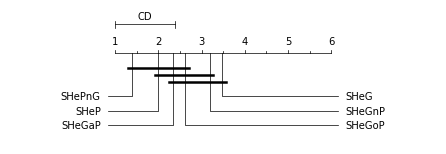

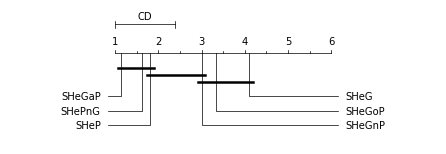

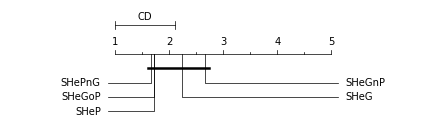

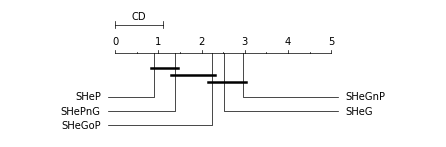

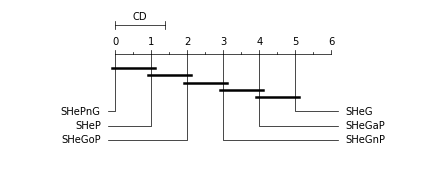

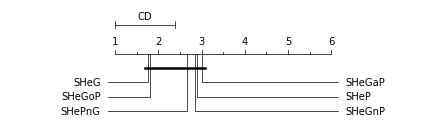

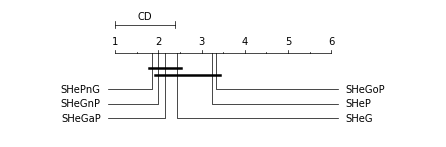

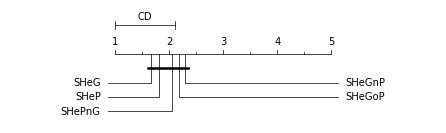

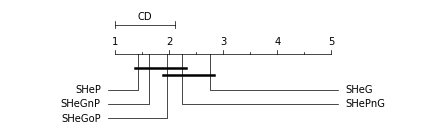

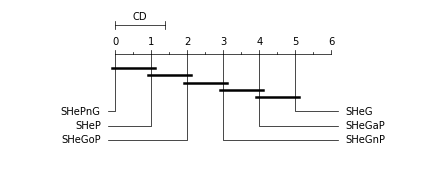

In [489]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'qualified_nodes']
embedding_types = ['Node2Vec', 'GCN']
group = 'th'

for i in block_list:
        for j in embedding_types:
            if i != group and i!='embedding':
                run_nemenyi_test(ff[ff['embedding'] == j], group, i )
                print('========')
            

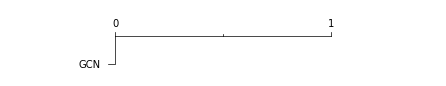

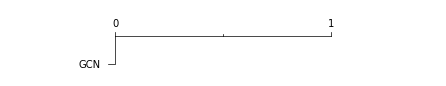

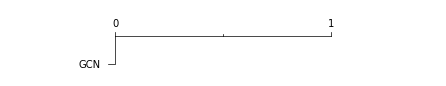

In [258]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'embedding']
embedding_types = ['Node2Vec', 'GCN']
group = 'graph_type'

for i in block_list:
#     for j in embedding_types:
#         if i != group and i!='embedding':
    run_nemenyi_test(ff[ff['embedding'] == j], group, i )
    print('========')


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=graph_type, block=embedding)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = embedding
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4


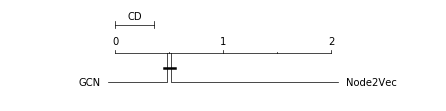

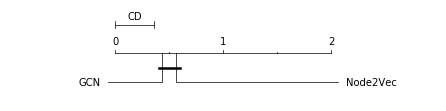

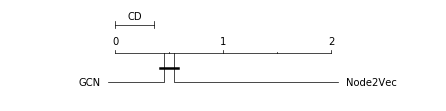

In [272]:
group = 'graph_type'

for i in block_list:
    if i != group:
        print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
        try:
            run_friedman_test(test_all_record_8, group, i)
        except:
            print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
        run_nemenyi_test(test_all_record_8, group, i )
            

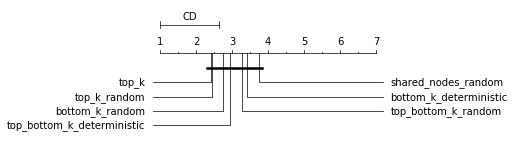

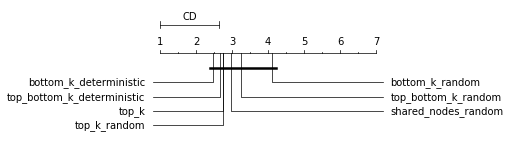

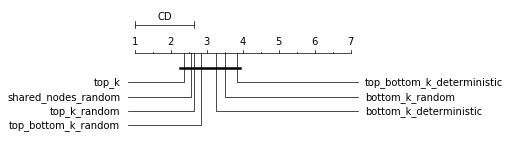

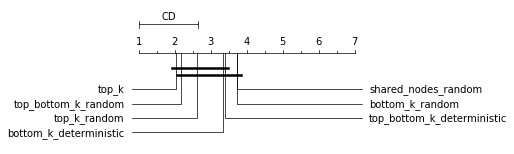

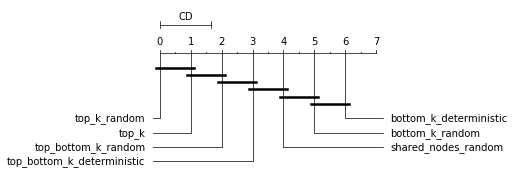

In [276]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'strategy']
embedding_types = ['Node2Vec', 'GCN']
group = 'th'

for i in block_list:
#     for j in embedding_types:
#         if i != group and i!='embedding':
        run_nemenyi_test(ff, group, i )
        print('========')
            

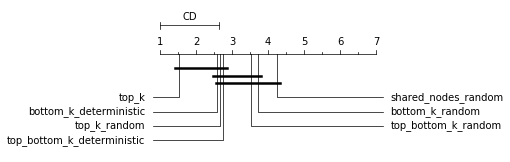

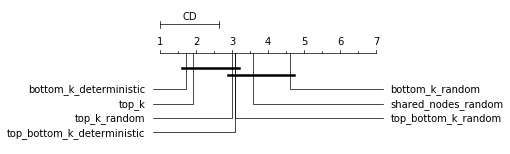

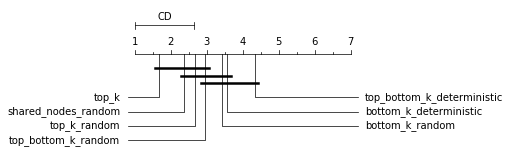

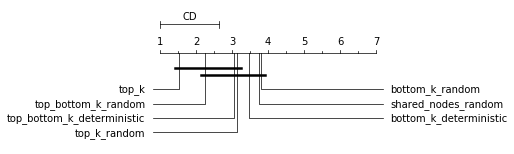

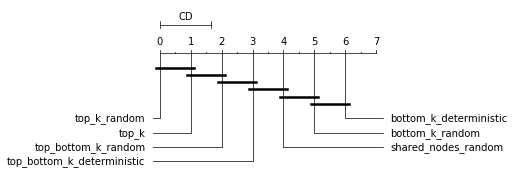

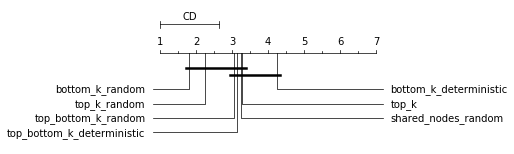

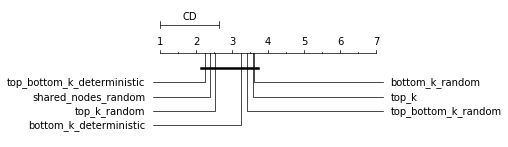

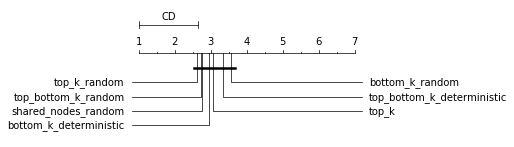

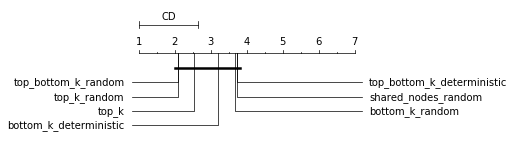

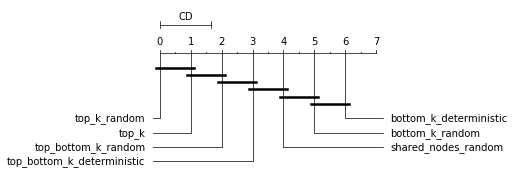

In [279]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'strategy']
embedding_types = ['Node2Vec', 'GCN']
group = 'th'

for i in block_list:
    for j in embedding_types:
        if i != group and i!='embedding':
            run_nemenyi_test(ff[ff['embedding'] == j], group, i )
            print('========')
            

In [409]:
tmp = test_all_record_7.copy()
ff = tmp.to_numpy()
ff = np.where(ff=='bottom_k_random', 'E-BAR', ff)
ff = np.where(ff=='top_k', 'E-TAD', ff)
ff = np.where(ff=='bottom_k_deterministic', 'E-BAD', ff)
ff = np.where(ff=='top_k_random', 'E-TAR', ff)
ff = np.where(ff=='top_bottom_k_deterministic', 'E-TBD', ff)
ff = np.where(ff=='top_bottom_k_random', 'E-TBR', ff)
ff = np.where(ff=='shared_nodes_random', 'E-SNR', ff)


ff = pd.DataFrame(ff, columns=tmp.columns)
get_unique_val(ff, 'qualified_nodes')

array(['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges',
       'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges',
       'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges'],
      dtype=object)

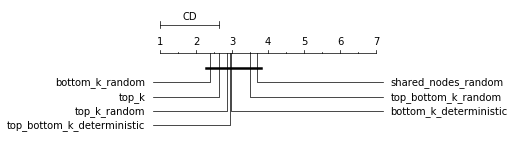

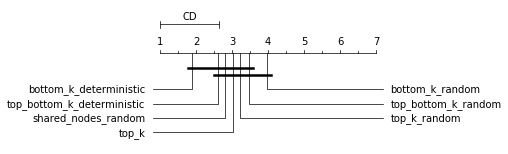

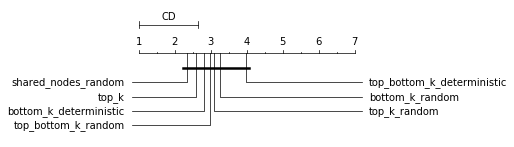

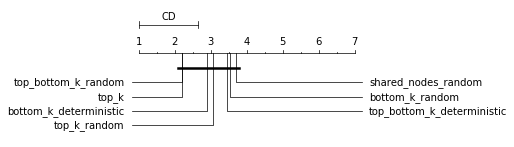

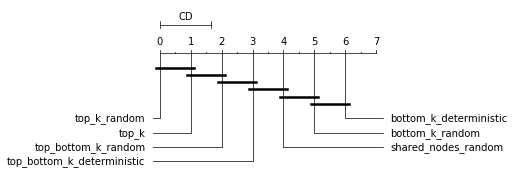

In [410]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'strategy']
embedding_types = ['Node2Vec', 'GCN']
group = 'th'

for i in block_list:
#     for j in embedding_types:
#         if i != group and i!='embedding':
    run_nemenyi_test(tmp, group, i )
    print('========')
            

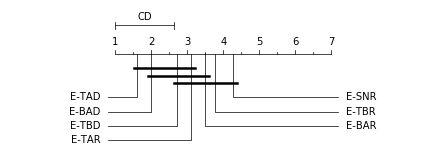

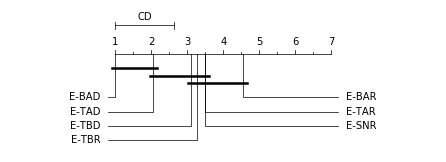

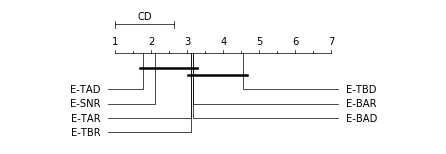

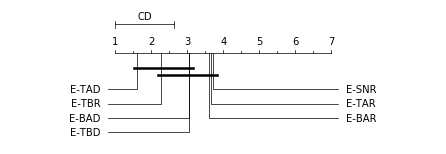

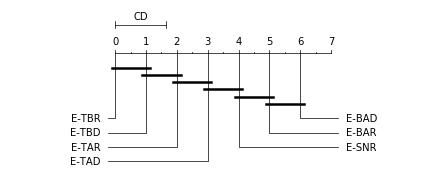

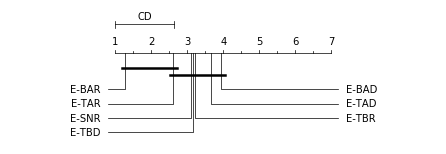

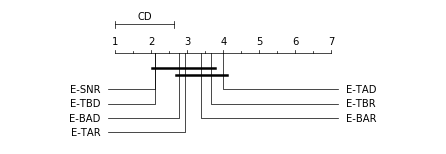

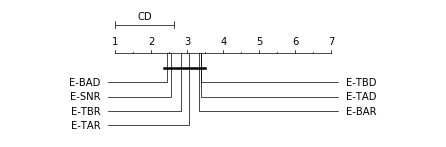

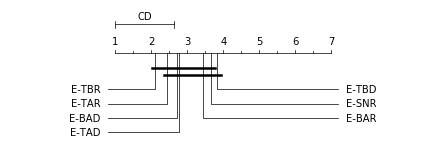

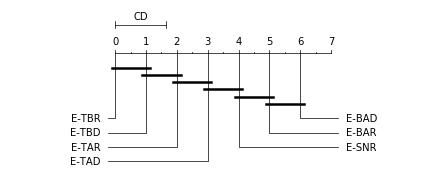

In [411]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'strategy']
embedding_types = ['Node2Vec', 'GCN']
group = 'th'

for i in block_list:
    for j in embedding_types:
        if i != group and i!='embedding':
            run_nemenyi_test(ff[ff['embedding'] == j], group, i )
            print('========')

        

In [298]:
ff[ff['embedding']=='GCN']

,th,qualified_nodes,embedding,strategy,classifier,graph_type,auc
0,no,SharedGeneAndPhenotypeEdges,GCN,BAD,svm,GD,0.784171
1,no,SharedGeneAndPhenotypeEdges,GCN,BAR,svm,GD,0.784171
2,no,SharedGeneAndPhenotypeEdges,GCN,SNR,svm,GD,0.784171
3,no,SharedGeneAndPhenotypeEdges,GCN,TBD,svm,GD,0.784171
4,no,SharedGeneAndPhenotypeEdges,GCN,TBR,svm,GD,0.784171
...,...,...,...,...,...,...,...
1437,0.5,SharedGeneAndPhenotypeEdges,GCN,no,svm,PGDP,0.791596
1438,0.05,SharedGeneAndPhenotypeEdges,GCN,no,svm,PGDP,0.791596
1439,0.1,SharedGeneAndPhenotypeEdges,GCN,no,svm,PGDP,0.791596
1440,0.4,SharedGeneAndPhenotypeEdges,GCN,no,svm,PGDP,0.791596


# Deviation from mean plot

In [365]:
get_unique_val(test_all_record_8, 'th')

array(['0.05', '0.1', '0.4', '0.5'], dtype=object)

In [366]:
tmp = test_all_record_8.groupby(['embedding','qualified_nodes', 'strategy', 'graph_type', 'th','auc'])
count = 0
bench_mark_list = []
for i,j in tmp:
#     count +=1
#     print(j.shape[0])
#     print(i)
    emb = i[0]
#     graph_type = i[1]
    qualified_nodes = i[1]
    strategy = i[2]
    graph_type = i[3]
    th = i[4]
    auc = i[5]
    
#     graph_type = i[1]
#     qualified_nodes = i[2]
#     strategy = i[3]
    
    for b in bench_mark:
#         count +=1
#         print(b)
        dd = list(b.values())[:-1]

#         emb_b = dd[2]
#         graph_type_b = dd[5]
#         qualified_nodes_b = dd[1]
#         th_b = dd[0]
#         classifier_b = dd[4]
#         strategy_b = dd[3]
#         bm_val = dd[-1] 
#         print(list(dd))
#         print(bm_val)

        emb_b = dd[2]
        graph_type_b = dd[4]
        qualified_nodes_b = dd[0]
        th_b = dd[5]
        classifier_b = dd[3]
        strategy_b = dd[1]
        bm_val = dd[-1] 
#         print(dd)
        
        if (emb_b == emb) and (graph_type_b == graph_type) and (qualified_nodes_b == qualified_nodes) and (strategy_b == strategy):
#         if (emb_b == emb) and (qualified_nodes_b == qualified_nodes) and (strategy_b == strategy):
            count+=1
#             print('hi')
#             print(bench_mark_val)
            bench_mark_val = {}
            bench_mark_val['th'] = th
            bench_mark_val['qualified_nodes'] = qualified_nodes_b
            bench_mark_val['embedding'] = emb_b
            bench_mark_val['strategy'] = strategy_b
            bench_mark_val['classifier'] = classifier_b
            bench_mark_val['graph_type'] = graph_type
            bench_mark_val['diff'] = auc - bm_val 
            bench_mark_list.append(bench_mark_val)

#             'th', 'qualified_nodes', 'embedding', 'strategy', 'classifier',
#        'graph_type', 'auc'
#         print()
#         print(len(b)) 
#         for k,v in b.items(): 
#             print(k)
#     print(j)
print(count)
# print(bench_mark_list)

5040


# GCN + GD

In [400]:
deviation_df = pd.DataFrame(bench_mark_list)

In [401]:
tmp = deviation_df.copy()
ff = tmp.to_numpy()
ff = np.where(ff=='bottom_k_random', 'E-BAR', ff)
ff = np.where(ff=='top_k', 'E-TAD', ff)
ff = np.where(ff=='bottom_k_deterministic', 'E-BAD', ff)
ff = np.where(ff=='top_k_random', 'E-TAR', ff)
ff = np.where(ff=='top_bottom_k_deterministic', 'E-TBD', ff)
ff = np.where(ff=='top_bottom_k_random', 'E-TBR', ff)
ff = np.where(ff=='shared_nodes_random', 'E-SNR', ff)


deviation_df = pd.DataFrame(ff, columns=tmp.columns)
get_unique_val(deviation_df, 'qualified_nodes')

array(['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges',
       'SharedGeneNotPhenotypeEdges', 'SharedGeneOrPhenotypeEdges',
       'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges'],
      dtype=object)

                            GD


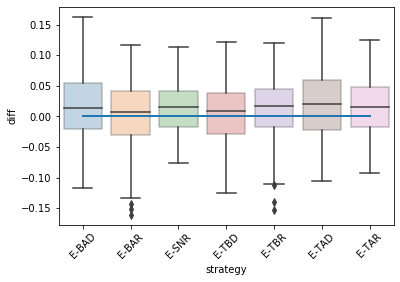

                            PGD


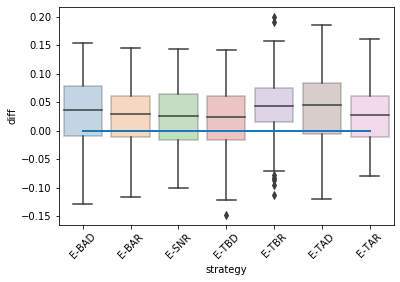

                            PGDP


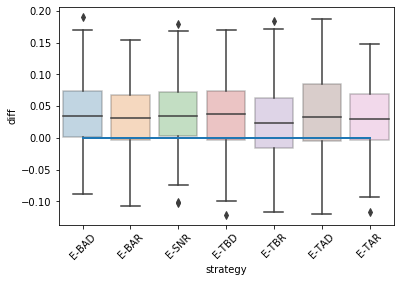

In [405]:
# tmp = deviation_df.groupby(['embedding','graph_type'])
tmp = deviation_df.groupby(['graph_type'])
# tmp = deviation_df.groupby(['embedding'])
# tmp = deviation_df.groupby(['qualified_nodes'])
for i,j in tmp:
#     print(j)
#     print(j.shape[0])
#     j['diff'].plot.bar()
#     j['diff'].plot(kind='bar',alpha=0.75, rot=45)
#     ax = sns.pointplot(x="strategy", y="diff", hue='qualified_nodes',data=j, join=False)
#     ax = sns.barplot(x="strategy", y="diff", hue='qualified_nodes',data=j)
    print(f'                            {i}')
#     if i[0] == 'GCN' and i[1] == 'GD':
#         j.iloc[:,-1] = j['diff'] + 0.03
    ax = sns.boxplot(x="strategy", y="diff",data=j, boxprops=dict(alpha=.3))
    plt.plot(np.zeros(7), linewidth=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#     sns.despine(ax=b, left=True, bottom=True)
    plt.show()

    

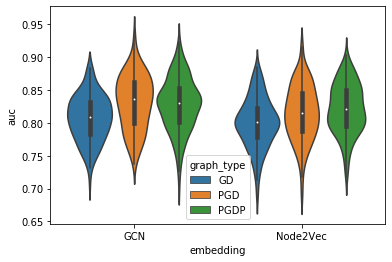

In [413]:
ax = sns.violinplot(x='embedding', y='auc' , hue='graph_type',data=test_all_record_8)

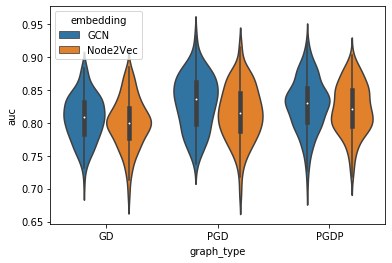

In [491]:
ax = sns.violinplot(x='graph_type', y='auc' , hue='embedding',data=test_all_record_8)

In [503]:
[i for i in bench_mark]

[{'th': 'no',
  'qualified_nodes': 'SharedGeneAndPhenotypeEdges',
  'embedding': 'GCN',
  'strategy': 'bottom_k_deterministic',
  'classifier': 'svm',
  'graph_type': 'GD',
  'auc': array([0.76594715])},
 {'th': 'no',
  'qualified_nodes': 'SharedGeneAndPhenotypeEdges',
  'embedding': 'GCN',
  'strategy': 'bottom_k_random',
  'classifier': 'svm',
  'graph_type': 'GD',
  'auc': array([0.76594715])},
 {'th': 'no',
  'qualified_nodes': 'SharedGeneAndPhenotypeEdges',
  'embedding': 'GCN',
  'strategy': 'shared_nodes_random',
  'classifier': 'svm',
  'graph_type': 'GD',
  'auc': array([0.76594715])},
 {'th': 'no',
  'qualified_nodes': 'SharedGeneAndPhenotypeEdges',
  'embedding': 'GCN',
  'strategy': 'top_bottom_k_deterministic',
  'classifier': 'svm',
  'graph_type': 'GD',
  'auc': array([0.76594715])},
 {'th': 'no',
  'qualified_nodes': 'SharedGeneAndPhenotypeEdges',
  'embedding': 'GCN',
  'strategy': 'top_bottom_k_random',
  'classifier': 'svm',
  'graph_type': 'GD',
  'auc': array([0.76

In [508]:
x = pd.DataFrame(bench_mark)
x[(x['embedding'] == 'Node2Vec') & (x['graph_type'] == 'PGD')]

,th,qualified_nodes,embedding,strategy,classifier,graph_type,auc
126,no,SharedGeneAndPhenotypeEdges,Node2Vec,bottom_k_deterministic,svm,PGD,[0.7735355958294317]
127,no,SharedGeneAndPhenotypeEdges,Node2Vec,bottom_k_random,svm,PGD,[0.7735355958294317]
128,no,SharedGeneAndPhenotypeEdges,Node2Vec,shared_nodes_random,svm,PGD,[0.7735355958294317]
129,no,SharedGeneAndPhenotypeEdges,Node2Vec,top_bottom_k_deterministic,svm,PGD,[0.7735355958294317]
130,no,SharedGeneAndPhenotypeEdges,Node2Vec,top_bottom_k_random,svm,PGD,[0.7735355958294317]
131,no,SharedGeneAndPhenotypeEdges,Node2Vec,top_k,svm,PGD,[0.7735355958294317]
132,no,SharedGeneAndPhenotypeEdges,Node2Vec,top_k_random,svm,PGD,[0.7735355958294317]
133,no,SharedGeneEdges,Node2Vec,bottom_k_deterministic,svm,PGD,[0.7735355958294317]
134,no,SharedGeneEdges,Node2Vec,bottom_k_random,svm,PGD,[0.7735355958294317]
135,no,SharedGeneEdges,Node2Vec,shared_nodes_random,svm,PGD,[0.7735355958294317]
